In [1]:
from hossam import *
from pandas import DataFrame, Series
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error)

from xgboost import XGBRegressor

from 성능평가함수 import *

In [2]:
origin=load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace=True)
origin['holiday']=origin['holiday'].astype('int')
origin['weekend']=origin['weekend'].astype('int')
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           353 non-null    float64
 1   visitors        353 non-null    int64  
 2   avg_price       353 non-null    int64  
 3   marketing_cost  353 non-null    float64
 4   delivery_ratio  353 non-null    float64
 5   rain_mm         353 non-null    float64
 6   temperature     353 non-null    float64
 7   holiday         353 non-null    int32  
 8   weekend         353 non-null    int32  
dtypes: float64(5), int32(2), int64(2)
memory usage: 24.8 KB


In [3]:
df=origin

yname='sales'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=52)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

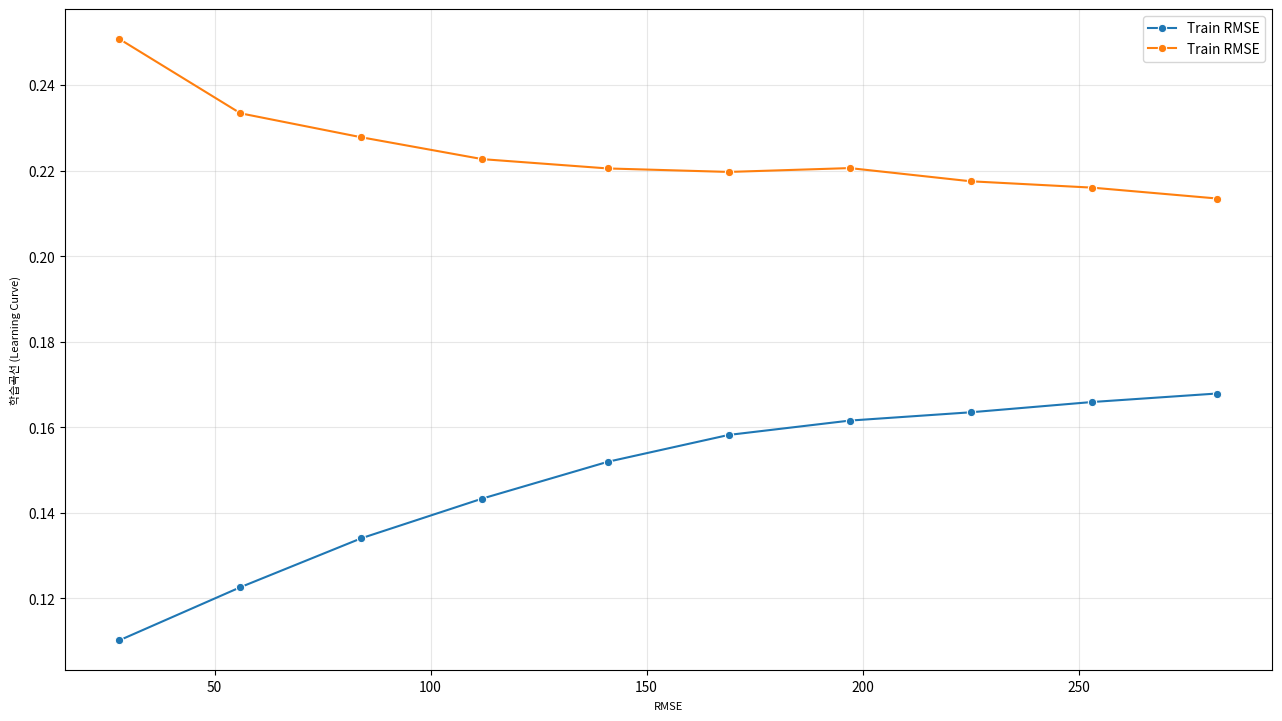

CPU times: total: 11 s
Wall time: 1min 52s


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
XGBRegressor,0.811,0.131,0.028,0.166,0.008,-0.007,0.168,0.213,0.015,0.787,0.069,⚠️ 과대적합 (variance 큼)


In [4]:
%%time

xgb=XGBRegressor(objective='reg:squarederror', random_state=52, n_jobs=-1, tree_method='hist')

param_grid={
    'n_estimators':[100, 300, 500],
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth':[3, 5, 7],
    'subsample':[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'reg_alpha':[0, 0.1, 1],
    'reg_lambda':[1, 5, 10]
}

gs=GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

gs.fit(x_train, y_train)

best_model=gs.best_estimator_

hs_get_score_cv(best_model, x_train, y_train, x, y)

In [5]:
booster=best_model.get_booster()

imp=booster.get_score(importance_type='gain')
imp

{'visitors': 0.15667177736759186,
 'avg_price': 0.25182339549064636,
 'marketing_cost': 0.35250067710876465,
 'delivery_ratio': 0.13085459172725677,
 'rain_mm': 0.25934603810310364,
 'temperature': 0.12791459262371063,
 'holiday': 2.4490013122558594,
 'weekend': 2.6400489807128906}

In [6]:
imp_sr=Series(imp)
imp_sr

visitors         0.157
avg_price        0.252
marketing_cost   0.353
delivery_ratio   0.131
rain_mm          0.259
temperature      0.128
holiday          2.449
weekend          2.640
dtype: float64

In [7]:
imp_df=DataFrame(imp_sr, columns=['importance'])
imp_df=imp_df.sort_values('importance', ascending=False)
imp_df

,importance
weekend,2.640
holiday,2.449
marketing_cost,0.353
rain_mm,0.259
avg_price,0.252
visitors,0.157
delivery_ratio,0.131
temperature,0.128


In [8]:
imp_df['ratio']=imp_df['importance']/imp_df['importance'].sum()
imp_df['cumsum']=imp_df['ratio'].cumsum()
imp_df

,importance,ratio,cumsum
weekend,2.640,0.415,0.415
holiday,2.449,0.385,0.799
marketing_cost,0.353,0.055,0.854
rain_mm,0.259,0.041,0.895
avg_price,0.252,0.040,0.935
visitors,0.157,0.025,0.959
delivery_ratio,0.131,0.021,0.980
temperature,0.128,0.020,1.000


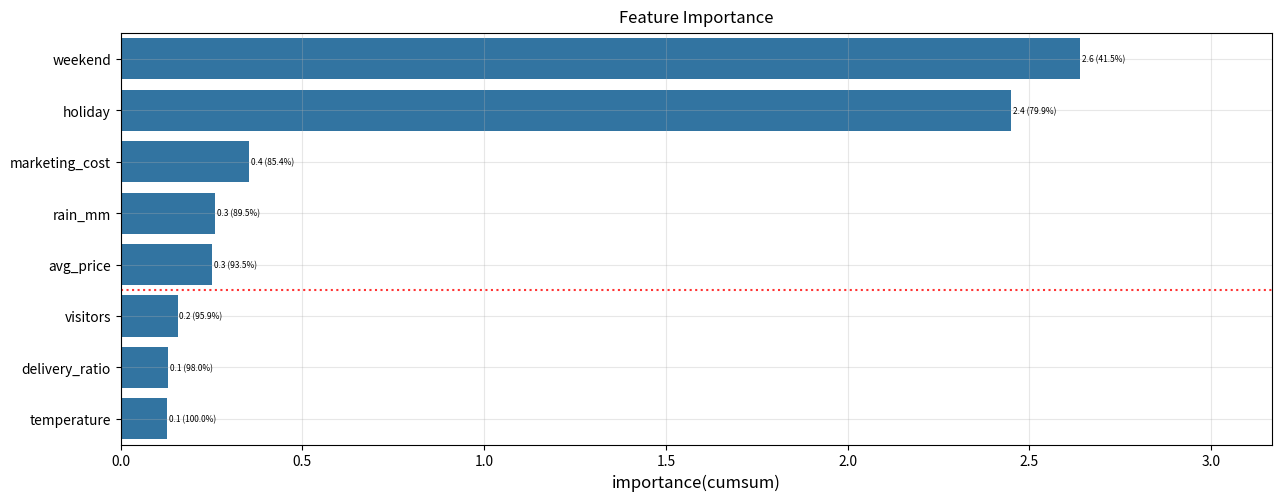

In [9]:
df=imp_df.sort_values(by='ratio', ascending=False)
threshold=0.9

figsize=(1280/100, 500/100)
fig, ax=plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=df, x='importance', y=df.index)

for i, v in enumerate(imp_df['importance']):
    ax.text(v+0.005, i, f'{v:.1f} ({imp_df.iloc[i]["cumsum"]*100:.1f}%)', va='center')

ax.set_title('Feature Importance', fontsize=12, pad=8)
ax.set_xlabel('importance(cumsum)', fontsize=12)
ax.set_ylabel(None)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, imp_df['importance'].max()*1.2)

cut_idx=np.argmax(imp_df['cumsum'].values>=threshold)

cut_rank=(int(cut_idx)+1)-0.5

plt.axhline(y=cut_rank, linestyle=':', color='red', alpha=0.8)

plt.tight_layout()
plt.show()
plt.close()

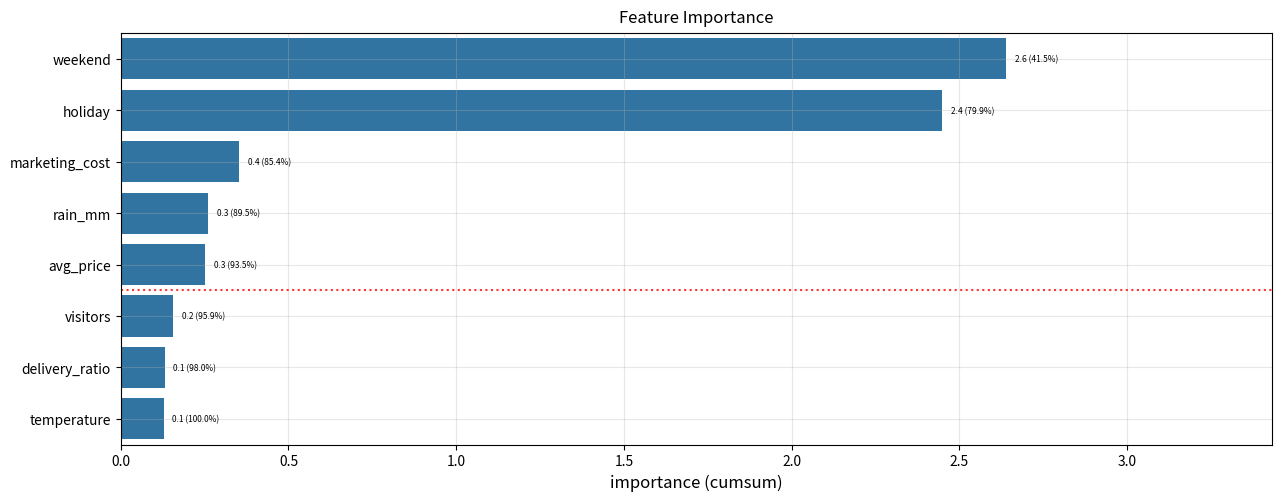

,importance,ratio,cumsum
weekend,2.640,0.415,0.415
holiday,2.449,0.385,0.799
marketing_cost,0.353,0.055,0.854
rain_mm,0.259,0.041,0.895
avg_price,0.252,0.040,0.935
visitors,0.157,0.025,0.959
delivery_ratio,0.131,0.021,0.980
temperature,0.128,0.020,1.000


In [10]:
hs_feature_importance(best_model, x_train, y_train)

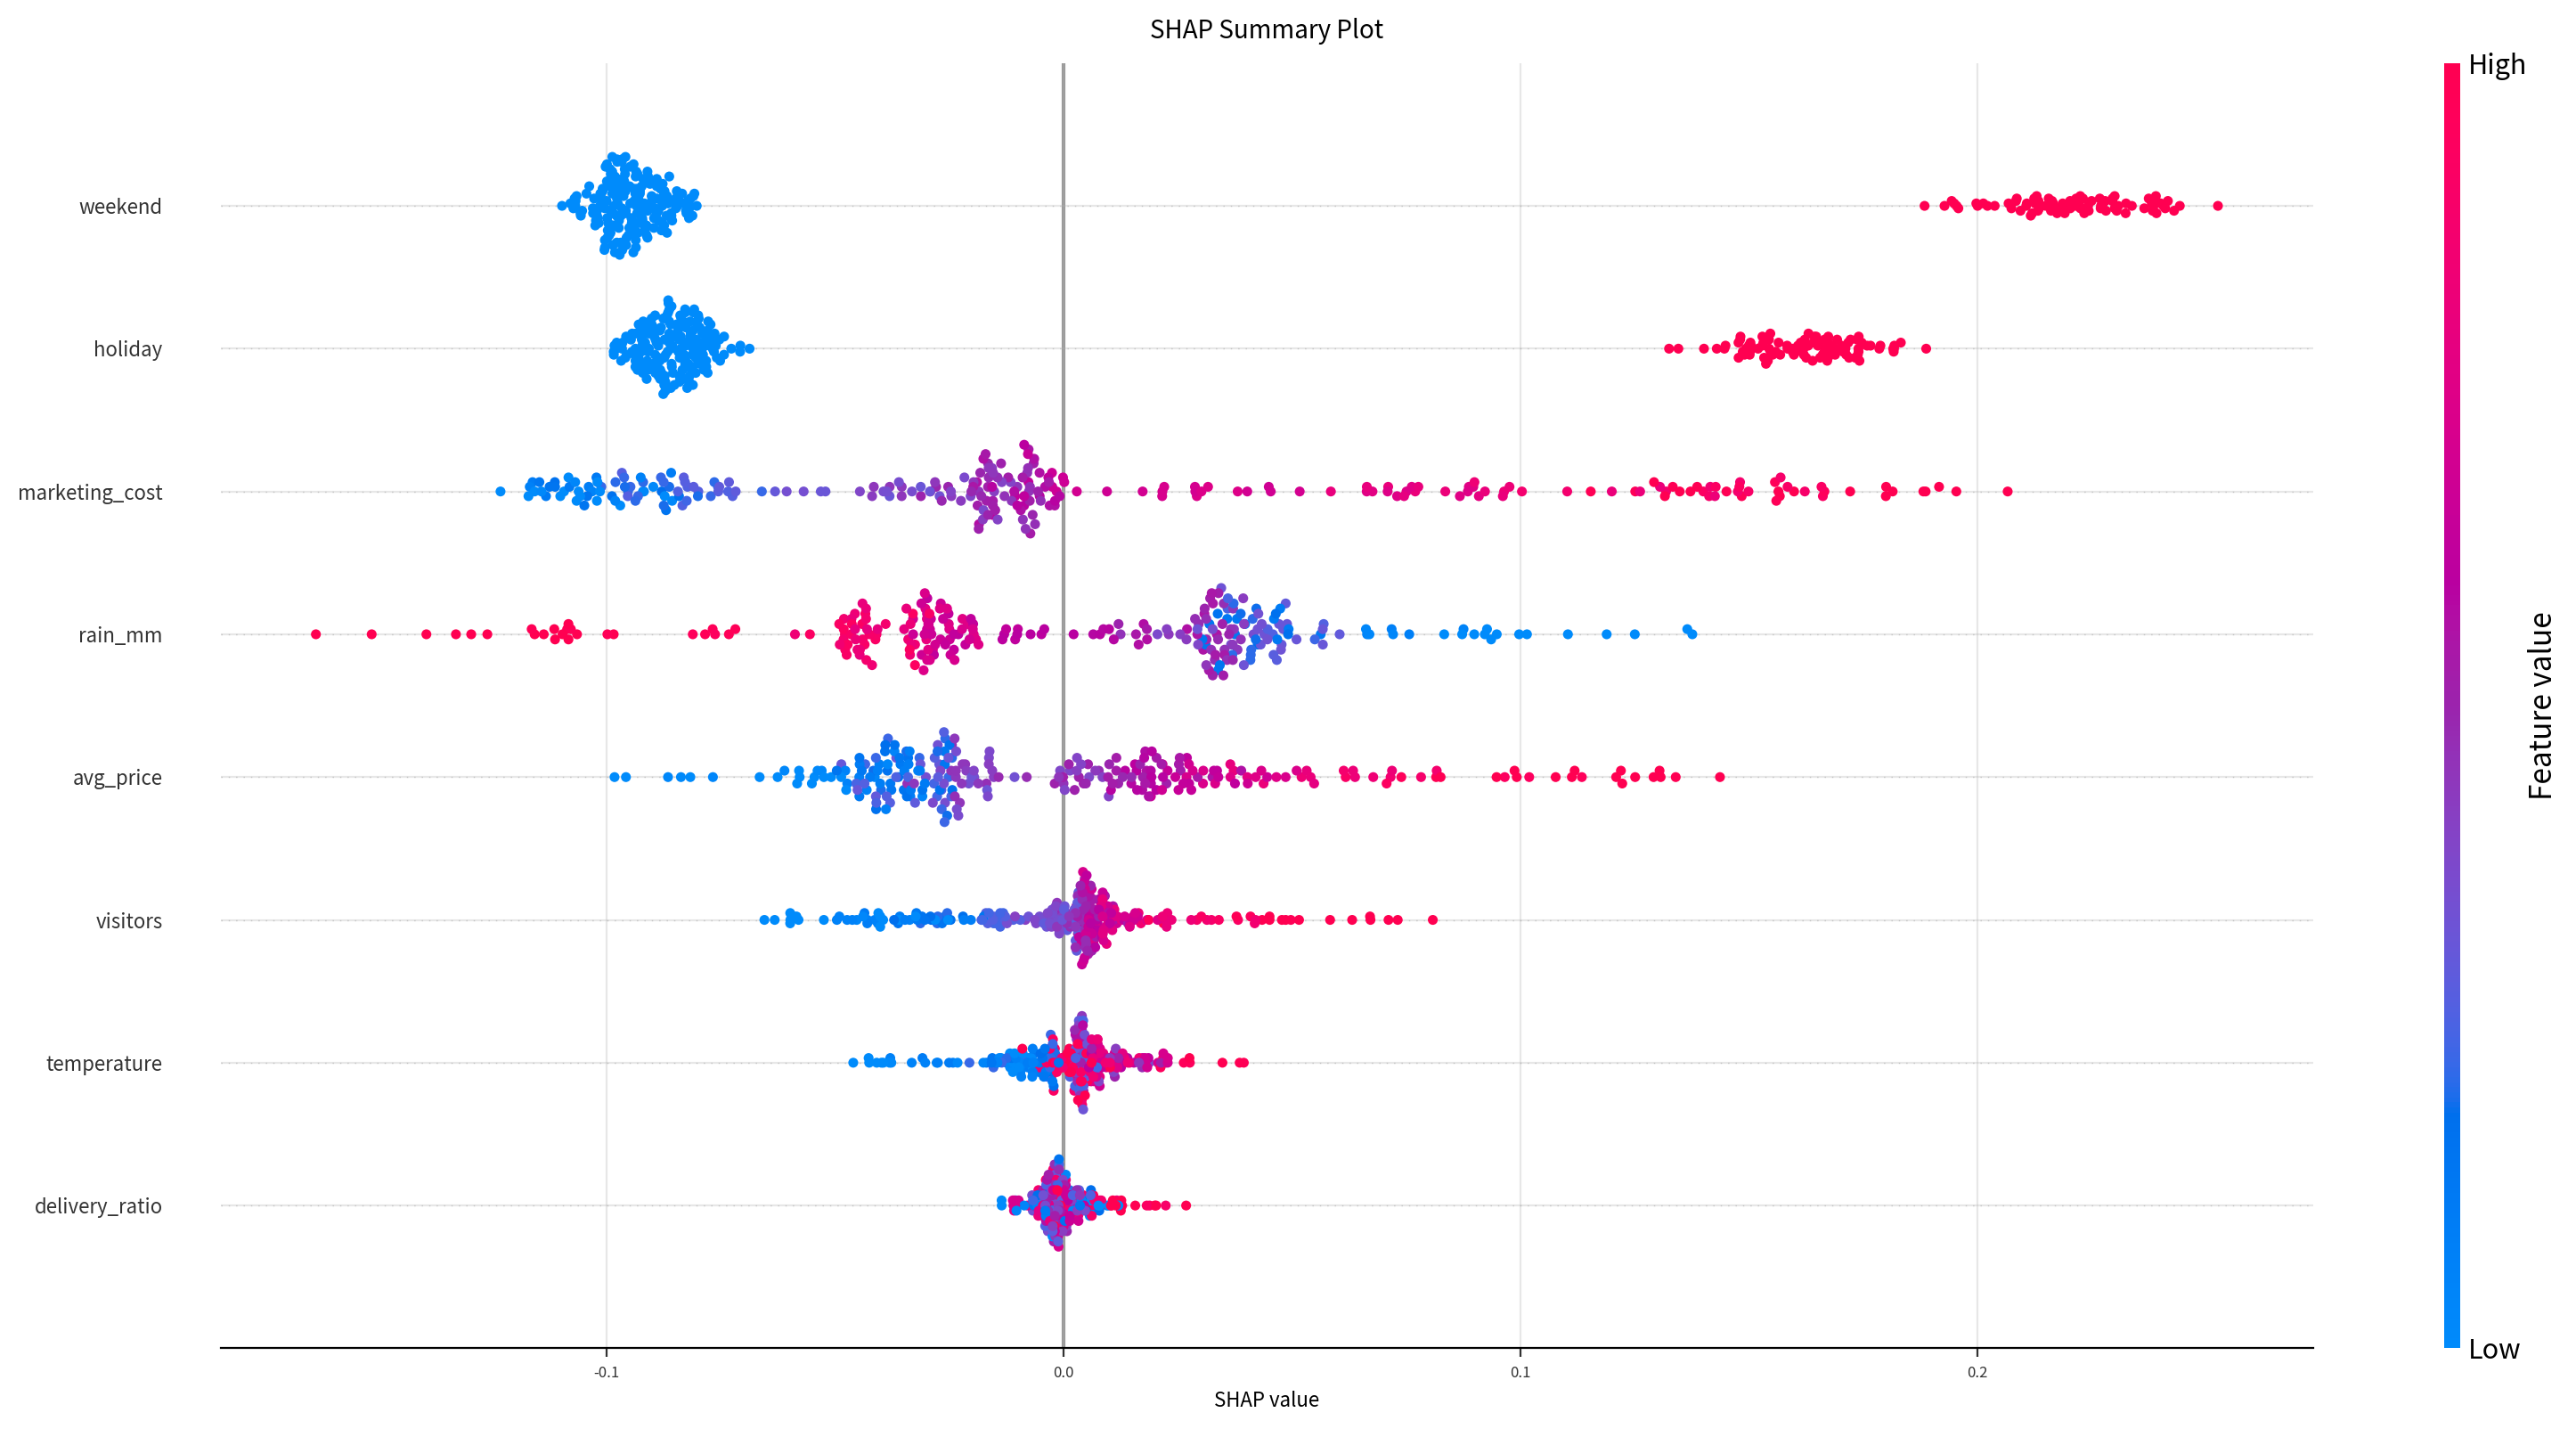

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,weekend,0.132,-0.000,0.145,음(-) 경향,1.096,variable,0.309,0.309,core
1,holiday,0.112,0.001,0.119,양(+) 경향,1.057,variable,0.263,0.572,core
2,marketing_cost,0.068,0.001,0.086,양(+) 경향,1.261,variable,0.160,0.731,core
3,rain_mm,0.046,-0.000,0.055,음(-) 경향,1.194,variable,0.107,0.838,secondary
4,avg_price,0.038,0.000,0.047,양(+) 경향,1.246,variable,0.089,0.927,secondary
5,visitors,0.017,-0.000,0.025,음(-) 경향,1.434,variable,0.041,0.968,secondary
6,temperature,0.010,0.001,0.013,양(+) 경향,1.386,variable,0.023,0.990,secondary
7,delivery_ratio,0.004,0.000,0.006,양(+) 경향,1.419,variable,0.010,1.000,secondary


In [11]:
result, _=hs_shap_analysis(best_model, x_train)
result